# Валидация. Способы разбиения выборки

Структура:  
1. Основные способы разделения выборки (Hold-out, cross_validate, StratifiedKFold, ShuffleSplit, LeavePOut, LeaveOneOut)  
2. hold-out (отложенная выборка)  
3. k-fold (cross-validation, перекрестная валидация)  
4. leave-one-out (отложенный пример)

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, LeaveOneOut
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_squared_error, roc_curve, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, f1_score, confusion_matrix)

# 1. Основные способы разделения выборки

- **Hold-out (train_test_split)** - Разделение имеющихся данных на тренировочный и тестовый наборы (или на train, valid и test).  
- **LeavePOut** - Разделение данных на две части с n - p и p наблюдениями, на первой идёт тренировка, вторая - для предсказания; ротация происходит по всем наблюдениям (это разбиение наиболее затратно по времени).    
- **LeaveOneOut** -  является частным чслучаем LeavePOut. Данные разделяют на две части с n - 1 и 1 наблюдением, на первой идёт тренировка, вторая - для предсказания; каждое наблюдение побывает во второй части.  
- **K-fold (cross_validate)** - Разделение данных на k частей, тренировка на k - 1 частях, тестирование на оставшейся; процесс повторяется для каждой части.    
- **StratifiedKFold** - k-fold cross validation с учётом количества наблюдений в классах.    
- **ShuffleSplit** - Аналог обычного разделения на тестовый и тренировочный датасэты с большим числом таких случайных разделений.


### Рассмотрим основные способы разбиения выборки на примере датасета load_iris  
Целевая переменная — класс цветка

In [16]:
# Загрузим датасет load_iris, подкорректируем целевую переменную для наглядности
iris = load_iris()
iris_data = pd.DataFrame(iris['data'], columns = iris['feature_names'])
name_map = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2:'Iris-virginica'}
# pd.Series(iris['target']).apply(lambda x: name_map[x])
# pd.Series(iris['target']).map(name_map)
iris_data['class'] = [name_map[i] for i in iris['target']]
display(iris_data.head(3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


# 2. Hold-out разбиение

При **hold-out** разбиении исходная выборка разделяется на обучающую и валидационную (+ опционально на тестовую) части в некотором соотношении. Как правило, на валидационную выборку отводится 20-40% данных. При выделении дополнительно тестовой выборки соотношение 60/20/20% или 70/15/15%.

Рекомендуется разбивать выборку на **train, valid и test**. Независимая тестовая выборка не используется при настройке параметров алгоритма. Тестирование в таком случае происходит честным путем — полученная на тестовой выборке метрика будет максимально близка к фактически посчитанной метрике в "боевых условиях".

#### a) разбиение на train и valid

In [16]:
train, valid = train_test_split(iris_data, test_size = 0.15, shuffle = True)

# Посмотрим размеры получившихся частей
print('Размер исходной выборки: {},\nРазмер обучающей выборки: {}\nРазмер валидационной выборки: {}'.
      format(iris_data.shape, train.shape, valid.shape))

Размер исходной выборки: (150, 5),
Размер обучающей выборки: (127, 5)
Размер валидационной выборки: (23, 5)


In [17]:
def visual_train_valid_proportion(init_data, train, valid):
    x = np.array([0, 1, 2])
    width = 0.2

    plt.figure(figsize = (15, 8))
    ax = plt.subplot(111)

    classes = list(init_data['class'].value_counts().index)

    ax.bar(x - width, list(init_data['class'].value_counts()[classes]), width, color = 'r', label = 'Исходные данные')
    ax.bar(x, list(train['class'].value_counts()[classes]), width, color = 'g', label = 'Тренировочная выборка')
    ax.bar(x, list(valid['class'].value_counts()[classes]), width, bottom = list(train['class'].value_counts()[classes]), color = 'b', label = 'Валидационная выборка')

    ax.set_ylim([0, 70])
    plt.xticks(x - width / 2, classes, fontsize = 20)
    plt.yticks(fontsize = 15)
    plt.ylabel('Кол-во примеров', fontsize = 20)
    plt.minorticks_on()
    plt.grid(which = 'major', color = 'r')
    plt.grid(which = 'minor', linestyle = ':', color = 'k')
    plt.legend(fontsize = 15)

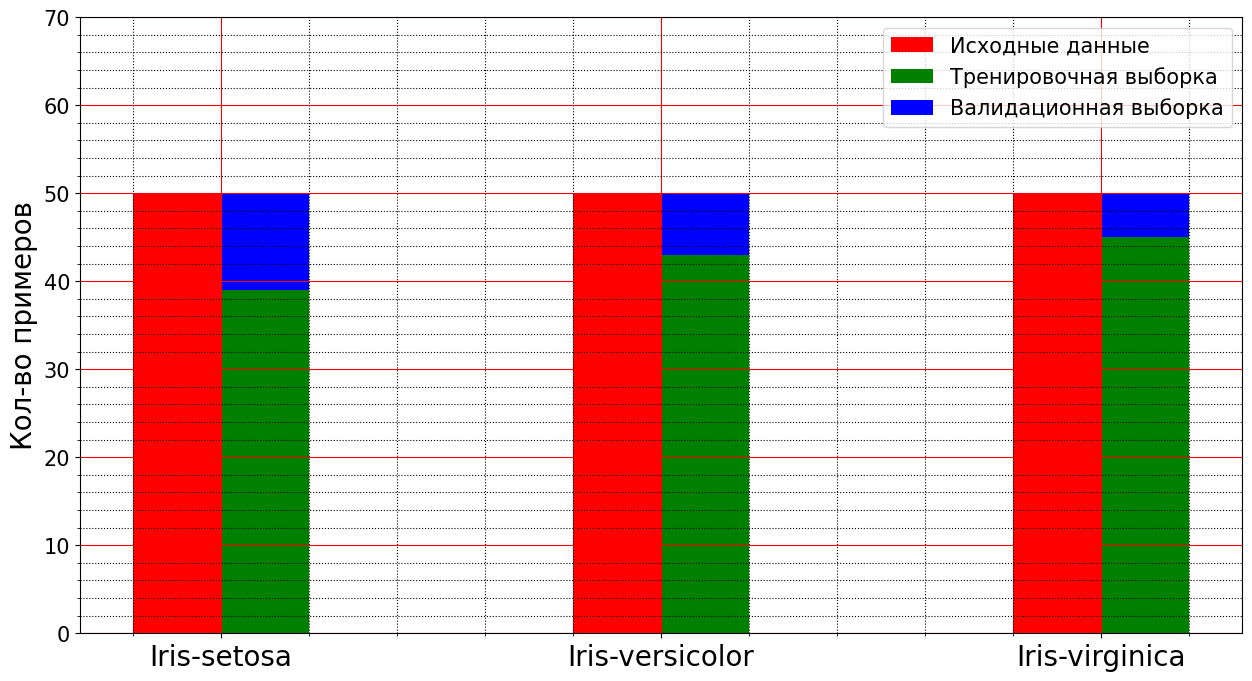

In [18]:
visual_train_valid_proportion(iris_data, train, valid)

Представлено три класса цветков, в каждом из которых разное количество примеров по выборкам. Получилось неравномерное распределение классов после разбиения, так как мы разбили выборку без учета долей классов.  
**Сделаем стратифицированное разбиение с помощью метода StratifiedShuffleSplit из библиотеки scikit-learn.** 

In [19]:
st_spl = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15)
train_indices, valid_indices = [split for split in st_spl.split(iris_data.iloc[:, :4], iris_data.iloc[:, 4])][0]
st_train = iris_data.iloc[train_indices]
st_valid = iris_data.iloc[valid_indices]

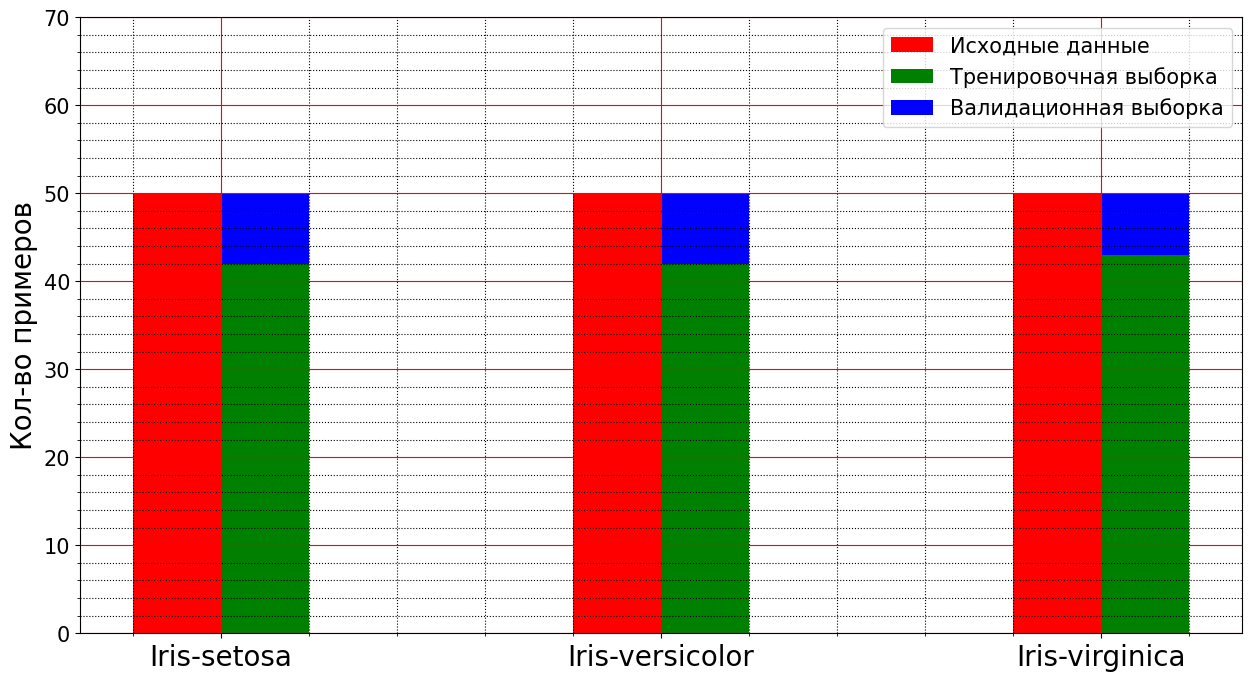

In [20]:
visual_train_valid_proportion(iris_data, st_train, st_valid)

В результате разбиение получилось практически одинаковым.

#### b) разбиение на train / valid / test

In [21]:
valid_part = 0.15
test_part = 0.15
valid_count = int(valid_part * iris_data.shape[0])
test_count = int(test_part * iris_data.shape[0])

train, valid_test = train_test_split(iris_data, test_size = valid_count + test_count)
valid, test = train_test_split(valid_test, test_size = test_count)
print('Размер исходной выборки: {}\nРазмер тренировочной выборки: {}\nРазмер валидационной выборки: {}\nРазмер тестовой выборки: {}'.
     format(iris_data.shape, train.shape, valid.shape, test.shape))

Размер исходной выборки: (150, 5)
Размер тренировочной выборки: (106, 5)
Размер валидационной выборки: (22, 5)
Размер тестовой выборки: (22, 5)


# 3. K-fold разбиение

[**Перекрестная проверка**](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0) (k-fold разбиение, скользящий контроль) — метод оценки поведения алгоритма на независимых данных, при котором исходная выборка разбивается на $k$ частей, на $k-1$ из которых производится обучение, а на $1$ валидация. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных.

In [22]:
kf = KFold(n_splits = 3, shuffle = False)
for train_index, valid_index in kf.split(iris_data):
    print('train_index: {}\nvalid_index: {}'.format(train_index, valid_index))
    print('=' * 20)

train_index: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149]
valid_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
train_index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 14

## 4. Leave-one-out разбиение

**leave-one-out** — разбиение, при котором в качестве обучающей выборки рассматриваются $n-1$ пример, а в качестве валидационной $1$ пример из исходной выборки. Сделаем leave-one-out разбиение 5-ти примеров из исходных данных:

In [23]:
lv_out = LeaveOneOut()
for train_index, valid_index in lv_out.split(iris_data[:5]):
    print('train_index: {}\nvalid_index: {}'.format(train_index, valid_index))
    print('=' * 20)

train_index: [1 2 3 4]
valid_index: [0]
train_index: [0 2 3 4]
valid_index: [1]
train_index: [0 1 3 4]
valid_index: [2]
train_index: [0 1 2 4]
valid_index: [3]
train_index: [0 1 2 3]
valid_index: [4]


Leave-one-out разбиение является частным случаем [Leave-P-out](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29) разбиения, при котором составляются комбинации из $p$ примеров исходных данных. Количество всевозможных комбинаций при таком разбиении составляет $C^p_n$ (или$\binom{n}{p}$), что вынуждает отказаться от использования этого метода при средних и больших объемах данных.  